# KMeans (Python only)

In this notebook, I explore KMeans algorithm in pure Python (no Numpy).

I do use Matplotlib for plotting only.

In [41]:
from typing import List
from copy import copy
import random
import csv
import math
from matplotlib import pyplot as plt
from collections import defaultdict

I saved two features from the Iris dataset to a CSV, as follows:

```python
pd.DataFrame(iris.data, columns=iris.feature_names)[iris.feature_names[:2]].to_csv("data/iris_2_feats.csv", index=False)
```

In [42]:
def load_dataset():
    output = []
    with open("data/iris_2_feats.csv") as fh:
        reader = csv.reader(fh)
        # Skip header
        next(reader)
        for row in reader:
            output.append([float(r) for r in row])
    return output

In [43]:
dataset = load_dataset()
dataset[:2]

[[5.1, 3.5], [4.9, 3.0]]

Let's see a Scatterplot of these points.

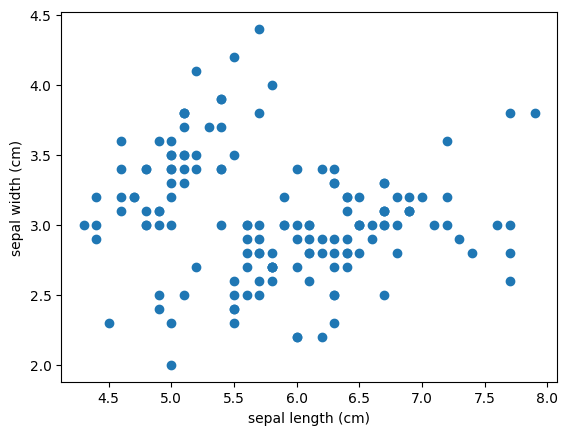

In [44]:
x = [d[0] for d in dataset]
y = [d[1] for d in dataset]
plt.scatter(x=x, y=y, )
plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")
plt.show()

Initially, I'll create 3 clusters.

In [45]:
K = 3

Initiase centers by picking 3 datapoints randomly.

In [46]:
cluster_centers = random.sample(dataset, k=K)
cluster_centers

[[5.8, 2.7], [6.5, 3.0], [6.0, 3.4]]

Firstly, normalise all the data, so it's between 0 and 1.

In [47]:
def normalise_data(data: List[List[float]]):
    if not data:
        return data

    output = copy(data)

    num_feats = len(output[0])

    mean_feats = {}
    for feat_idx in range(num_feats):        
        mean_feat = sum([d[feat_idx] for d in data]) / len(data)
        std_feat = sum([((d[feat_idx] - mean_feat)**2) for d in data]) / len(data)

        for i in range(len(data)):
            output[i][feat_idx] = (output[i][feat_idx] - mean_feat) / std_feat

    return output

In [48]:
assert normalise_data([[2, 6], [4, 8]]) == [[-1.0, -1.0], [1.0, 1.0]]

In [49]:
norm_data = normalise_data(dataset)
norm_data[:2]

[[-1.0913361935368127, 2.345715066273514],
 [-1.384969250093801, -0.3038124935233816]]

Now a distance function. I'll use Euclidean distance.

In [50]:
def distance(point1, point2):
    """Use Euclidean distance formula."""
    squared_differences = sum([
        (a - b) ** 2
        for a, b in zip(point1, point2)
    ])
    return math.sqrt(squared_differences)

In [51]:
assert distance([1,2], [1,4]) == 2

We need a function that will find the closest center. We use a very typical pattern of keeping track of the lowest value and index, and updating both when we find a new lowest.

In [52]:
def get_closest_center(point: List[float], cluster_centers: List[List[float]]) -> int:
    lowest_dist = float("inf")
    lowest_idx = None

    for idx, cluster_center in enumerate(cluster_centers):
        dist = distance(point, cluster_center)
        if dist < lowest_dist:
            lowest_dist = dist
            lowest_idx = idx

    return lowest_idx

In [53]:
assert get_closest_center([3.], [[2], [1], [3]]) == 2

Let's do one pass of K-Means now. We'll create a dict to store out mapping between datapoint idx and cluster center inx.

Loop through all our data, find the closest centroid and store in the map.

In [20]:
def find_closest_centers(norm_data):
    datapoint_to_centroid = {}
    for data_idx, data in enumerate(norm_data):
        closest_idx = get_closest_center(data, cluster_centers)
        datapoint_to_centroid[data_idx] = closest_idx
    return datapoint_to_centroid

datapoint_to_centroid = find_closest_centers(norm_data)

Let's create a function that calculates the average distance between each datapoint and their closest centroid.

This serves as an overall measure of quality for our K-Means cluster.

In [21]:
def get_avg_distance(norm_data, cluster_centers, datapoint_to_centroid):
    total_dist = 0
    for data_idx, data in enumerate(norm_data):
        total_dist += distance(data, cluster_centers[datapoint_to_centroid[data_idx]])
        
    avg_dist = total_dist / len(norm_data)
    return avg_dist

avg_dist = get_avg_distance(norm_data, cluster_centers, datapoint_to_centroid)
avg_dist

1.9754773822471012

Now we can update our cluster centers.

Walk through data. For each feature, add feature to running total for cluster center.

In [22]:
cluster_centers

[[1.6981778437545862, 0.7559985303953777],
 [2.579077013425554, -0.3038124935233816],
 [-0.5040700804228335, -2.4234345413608978]]

In [23]:
def assign_new_cluster_centers(cluster_centers, norm_data, datapoint_to_centroid):
    new_cluster_centers = [[0] * len(c) for c in cluster_centers]
    for data_idx, data in enumerate(norm_data):
        cluster_idx = datapoint_to_centroid[data_idx]
        for feat_idx, feat in enumerate(data):
            new_cluster_centers[cluster_idx][feat_idx] += feat
    
    for cluster_idx, cluster in enumerate(new_cluster_centers):
        for feat_idx in range(len(cluster)):
            cluster[feat_idx] /= len(norm_data)

    return new_cluster_centers
        
cluster_centers = assign_new_cluster_centers(cluster_centers, norm_data, datapoint_to_centroid)
cluster_centers

[[0.03278902464886297, 0.8407834123088794],
 [0.14355393876119465, -0.06264660719164244],
 [-0.17634296341005945, -0.7781368051172411]]

In [24]:
max_iters = 20
norm_data = normalise_data(dataset)
cluster_centers = random.sample(norm_data, k=K)
cur_dist = None

for i in range(max_iters):
    datapoint_to_centroid = find_closest_centers(norm_data)
    avg_dist = get_avg_distance(norm_data, cluster_centers, datapoint_to_centroid)
    if cur_dist and abs(cur_dist - avg_dist) <= 1e-8:
        break
    cur_dist = avg_dist
    cluster_centers = assign_new_cluster_centers(cluster_centers, norm_data, datapoint_to_centroid)
    print(avg_dist)

0.8374117912198782
0.6566494089085856
0.6102434432079757
0.6100420530262163
